# DE-MC sampling of MLP weights using iris data

Sampling the weights of a multi-layer perceptron (MLP) using the iris data and DE-MC algorithm.

In [1]:
## Import packages

import numpy as np

import torch
import torch.nn as nn

from torch.utils.data import DataLoader
from torch.distributions import Normal

from eeyore.api import indexify
from eeyore.data import Iris
from eeyore.models import mlp
from eeyore.mcmc import DEMC

from timeit import default_timer as timer
from datetime import timedelta

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
## Avoid issuing memory warning due to number of plots

plt.rcParams.update({'figure.max_open_warning': 0})

In [3]:
## Load iris data

num_chains = 100

dataloaders = [DataLoader(indexify(Iris)(), batch_size=150, shuffle=True) for _ in range(num_chains)]

In [4]:
## Setup MLP model

hparams = mlp.Hyperparameters(dims=[4, 3, 3], activations=[torch.sigmoid, None])

models = [mlp.MLP(
    hparams=hparams,
    loss=lambda x, y: nn.CrossEntropyLoss(reduction='sum')(x, torch.argmax(y, 1)),
    dtype=torch.float64
) for i in range(num_chains)]

for i in range(num_chains):
    models[i].prior = Normal(
        torch.zeros(models[i].num_params(), dtype=models[i].dtype),
        np.sqrt(3)*torch.ones(models[i].num_params(), dtype=models[i].dtype)
    )

In [5]:
## Set initial values of chains

theta0 = models[num_chains-1].prior.sample()
theta0s = [theta0.clone().detach() for _ in range(num_chains)]

In [6]:
## Setup DEMC sampler

sigmas = [torch.tensor(models[i].num_params()*[0.0001], dtype=models[i].dtype) for i in range(num_chains)]
c = [0.01 for _ in range(num_chains)]
sampler = DEMC(models, theta0s, dataloaders, sigmas, num_chains=num_chains, c=c)

In [7]:
## Run PowerPosteriorSampler

start_time = timer()

sampler.run(num_iterations=1100, num_burnin=100, verbose=True, verbose_step=100)

end_time = timer()
print("Time taken: {}".format(timedelta(seconds=end_time-start_time)))

Iteration  100, duration 0:00:00.137560
Iteration  200, duration 0:00:00.144328
Iteration  300, duration 0:00:00.151619
Iteration  400, duration 0:00:00.157227
Iteration  500, duration 0:00:00.151511
Iteration  600, duration 0:00:00.148608
Iteration  700, duration 0:00:00.143193
Iteration  800, duration 0:00:00.150782
Iteration  900, duration 0:00:00.148464
Iteration 1000, duration 0:00:00.147765
Iteration 1100, duration 0:00:00.146793
Time taken: 0:02:43.048156


In [8]:
## Compute Monte Carlo mean

torch.stack([sampler.chains[i].mean() for i in range(num_chains)]).mean(0)

tensor([-1.1987,  1.6558, -2.2364,  3.3448,  1.6940, -0.2886,  0.5119,  1.9161,
         1.0356, -0.1932, -1.9468,  0.2206,  0.3133, -0.4997,  1.6682,  0.6657,
         1.7902,  1.2221,  2.3117,  1.3206, -1.0922,  1.6629, -0.4932, -0.8217,
         0.3063, -1.5206,  4.0347], dtype=torch.float64)

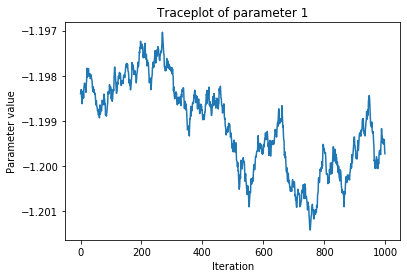

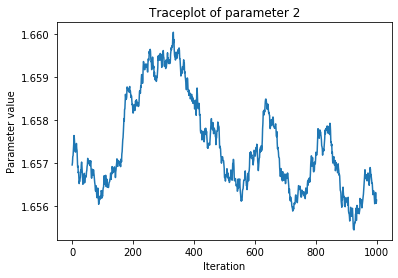

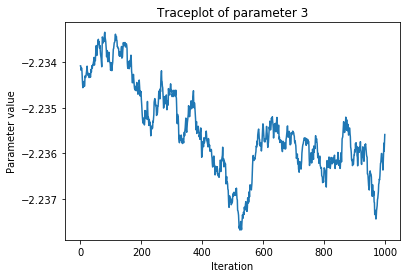

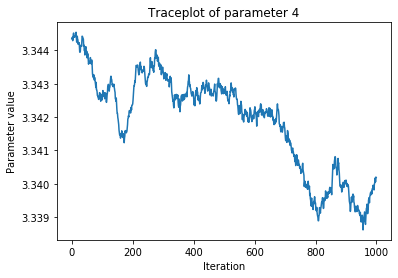

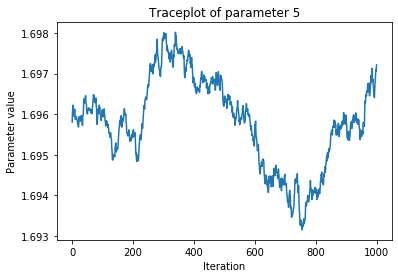

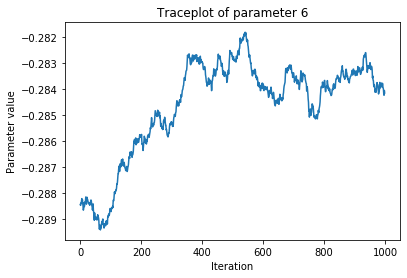

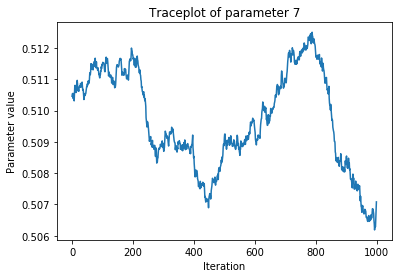

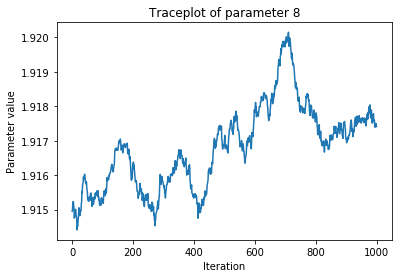

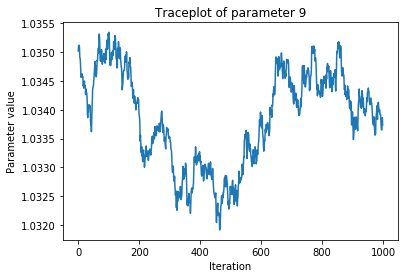

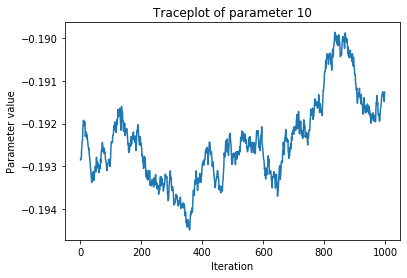

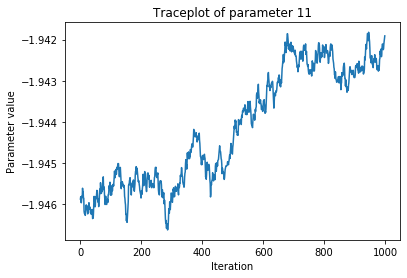

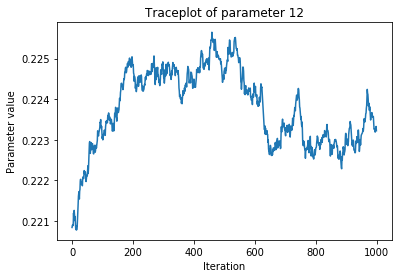

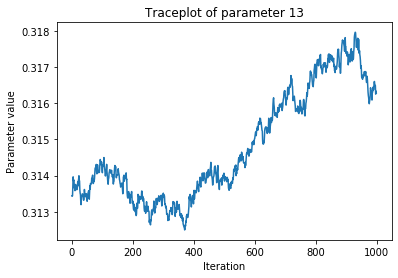

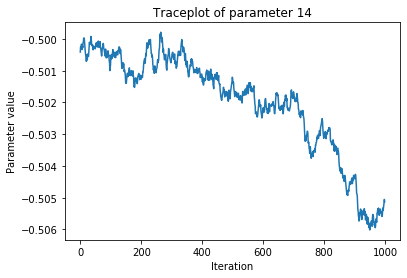

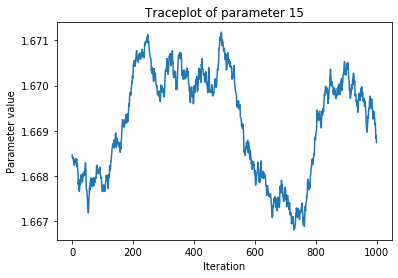

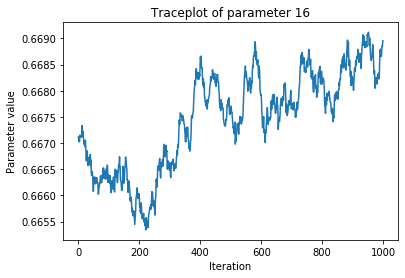

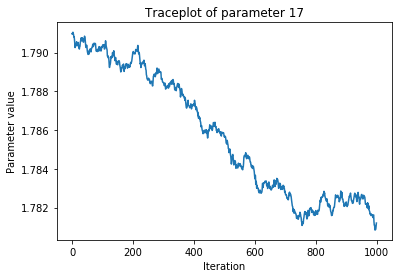

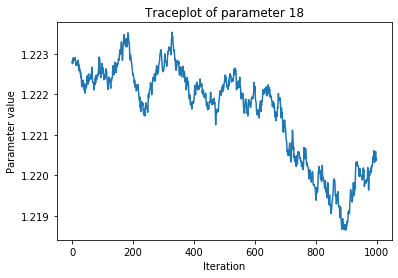

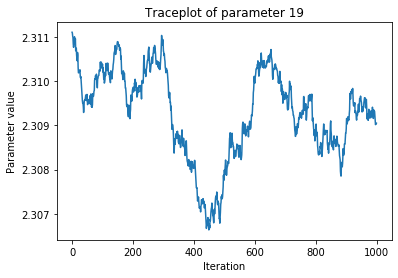

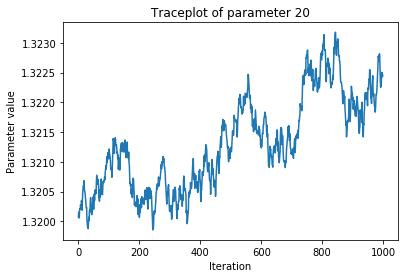

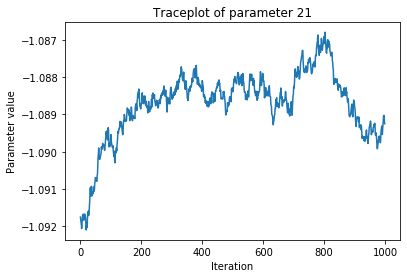

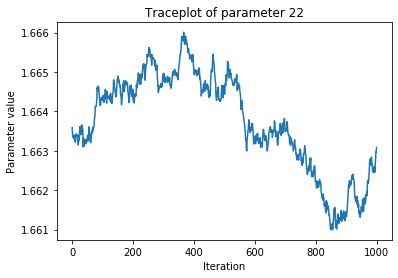

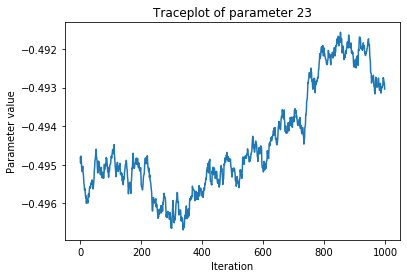

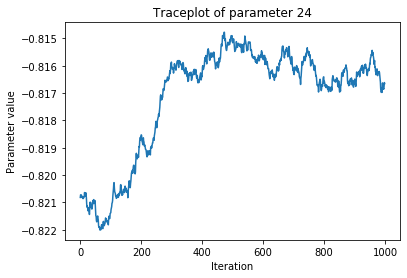

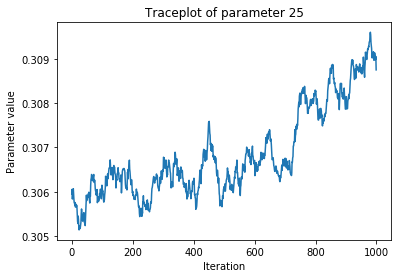

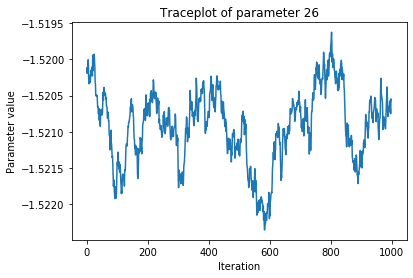

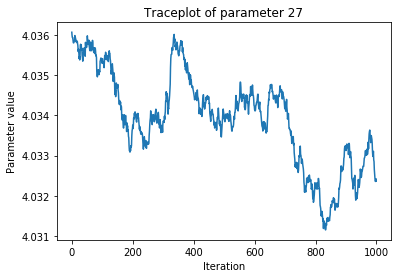

In [9]:
## Plot traces of simulated Markov chain

for i in range(sampler.models[0].num_params()):
    chain = sampler.samplers[0].chain.get_theta(i)
    plt.figure()
    sns.lineplot(range(len(chain)), chain)
    plt.xlabel('Iteration')
    plt.ylabel('Parameter value')
    plt.title(r'Traceplot of parameter {}'.format(i+1))

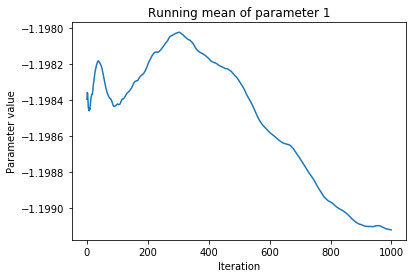

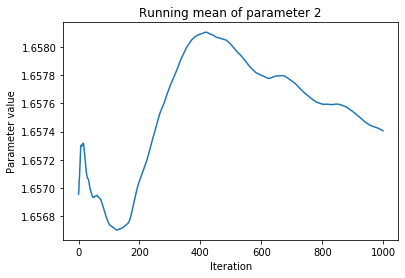

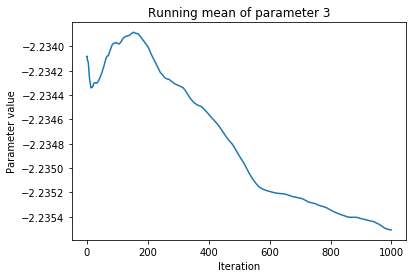

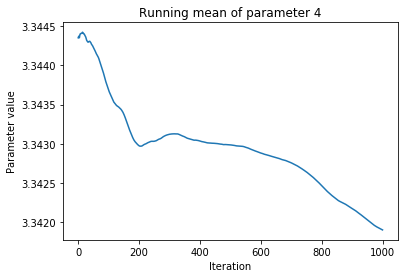

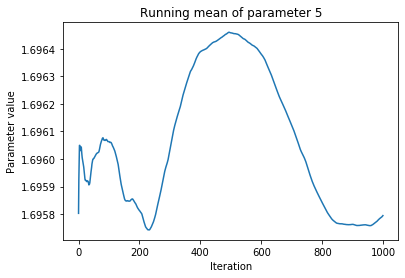

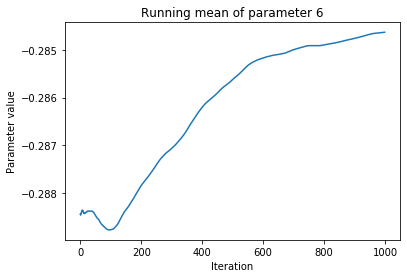

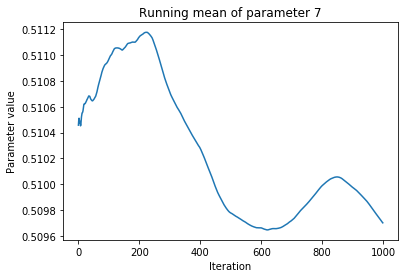

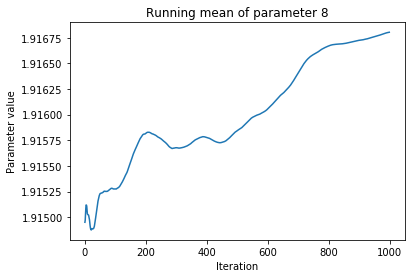

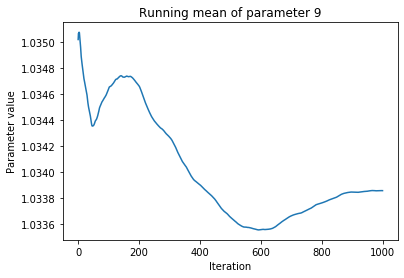

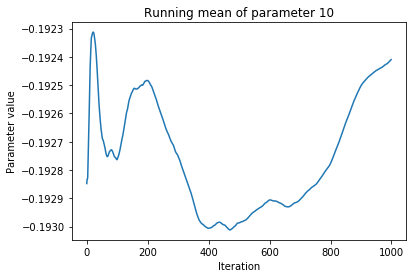

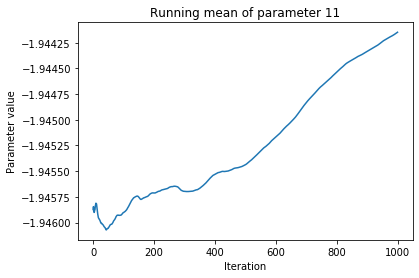

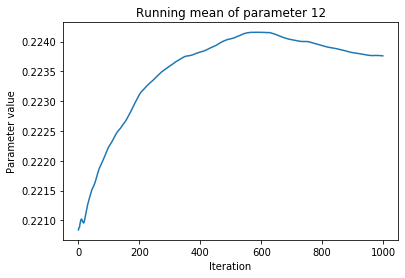

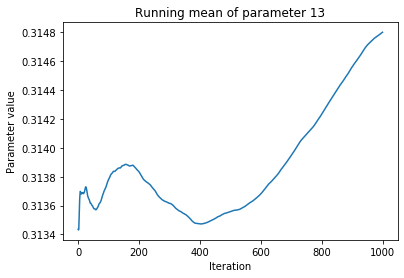

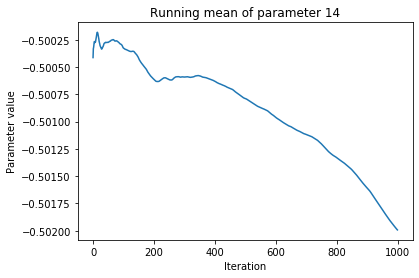

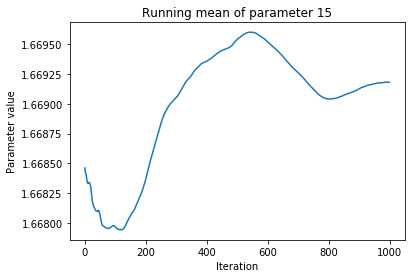

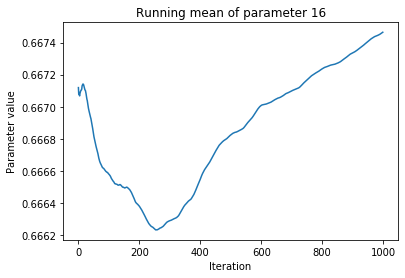

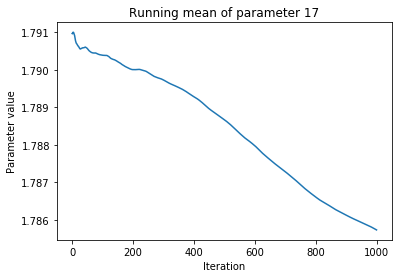

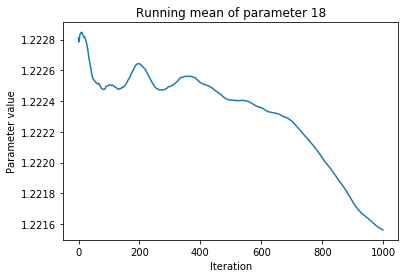

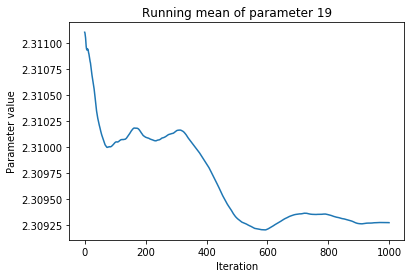

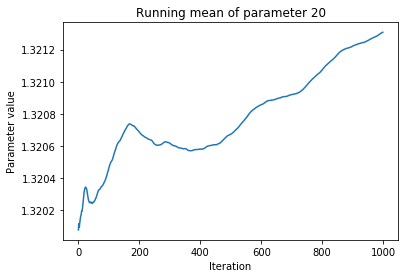

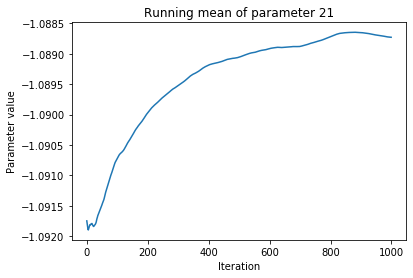

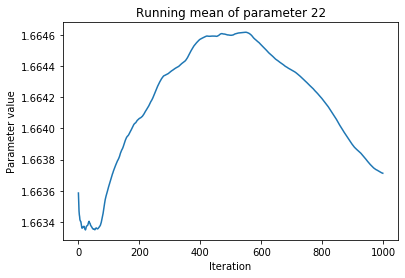

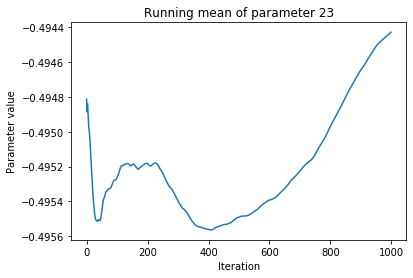

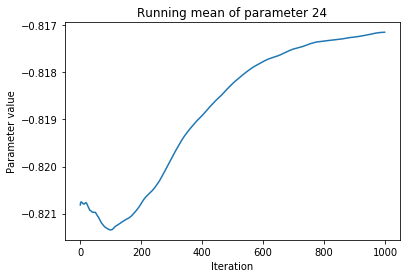

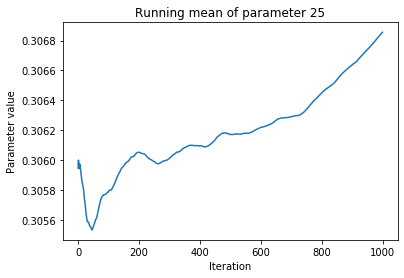

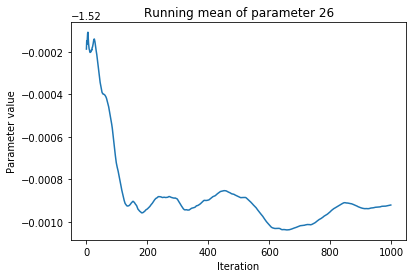

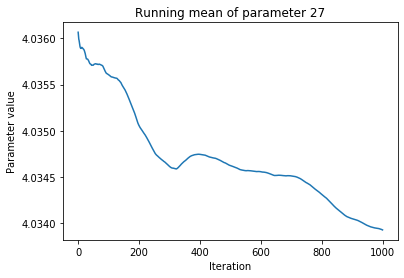

In [10]:
## Plot running means of simulated Markov chain

for i in range(sampler.models[0].num_params()):
    chain = sampler.samplers[0].chain.get_theta(i)
    chain_mean = torch.empty(len(chain))
    chain_mean[0] = chain[0]
    for j in range(1, len(chain)):
        chain_mean[j] = (chain[j]+j*chain_mean[j-1])/(j+1)
        
    plt.figure()
    sns.lineplot(range(len(chain)), chain_mean)
    plt.xlabel('Iteration')
    plt.ylabel('Parameter value')
    plt.title(r'Running mean of parameter {}'.format(i+1))

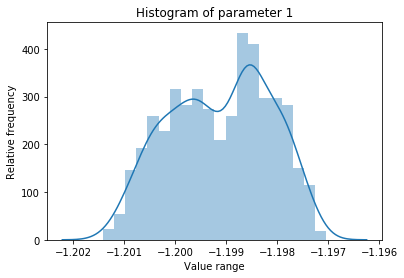

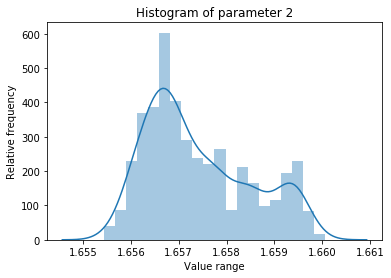

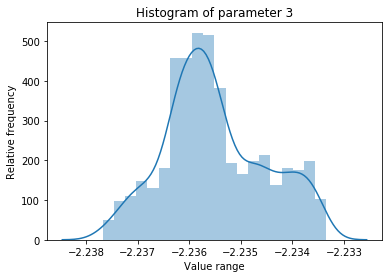

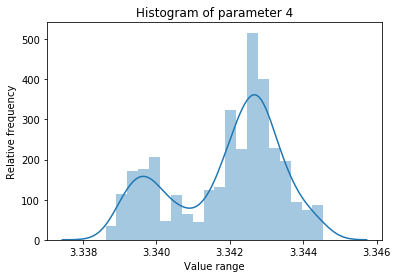

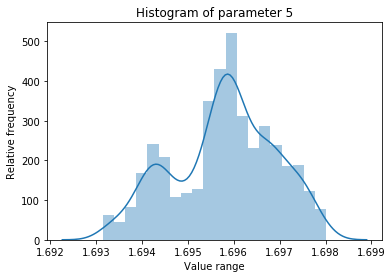

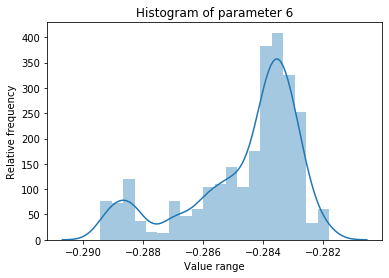

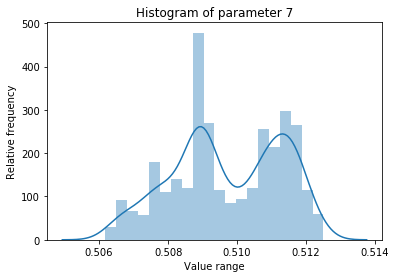

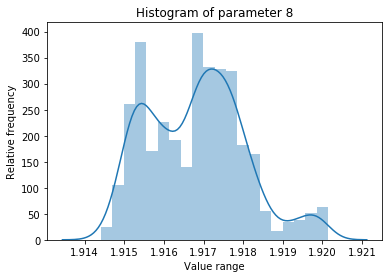

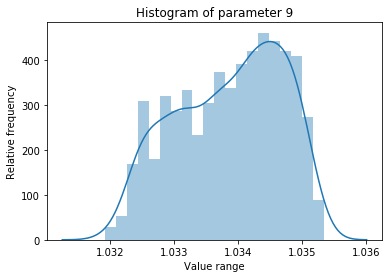

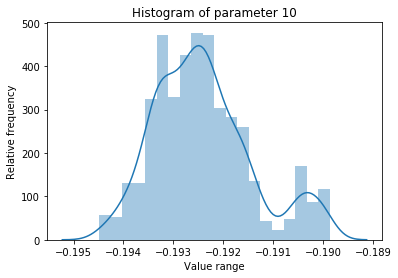

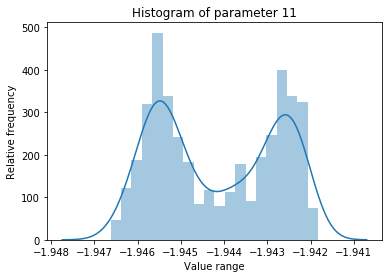

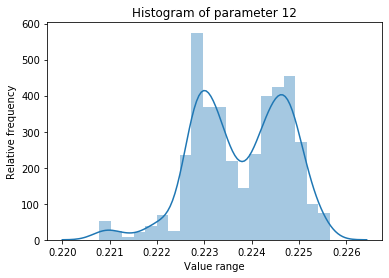

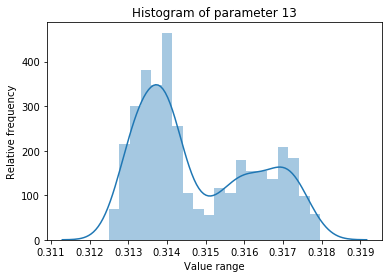

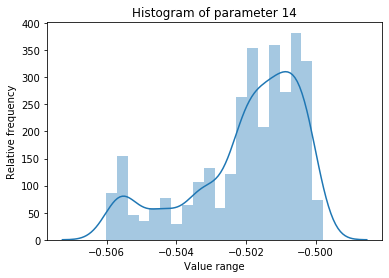

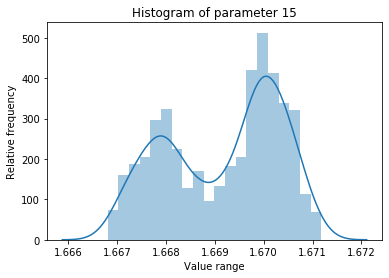

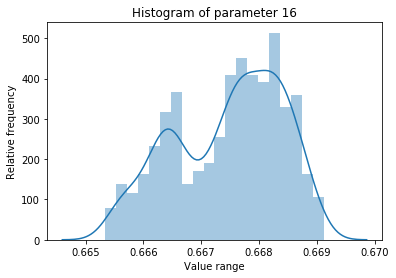

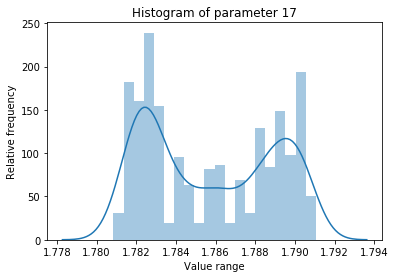

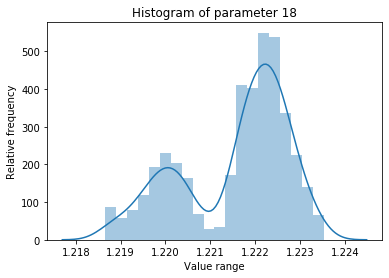

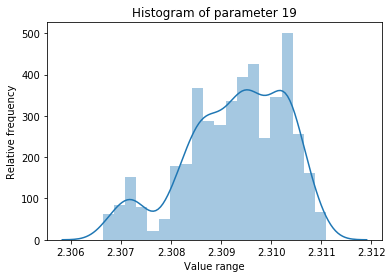

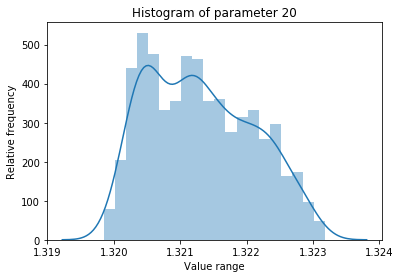

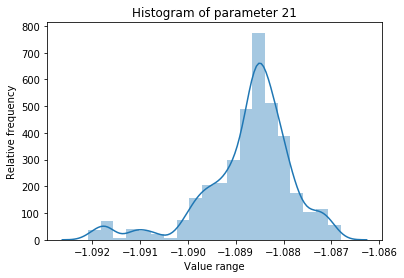

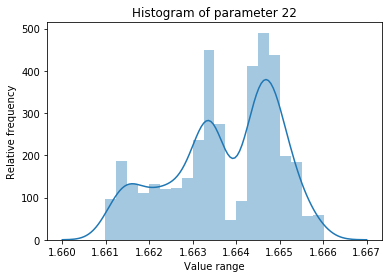

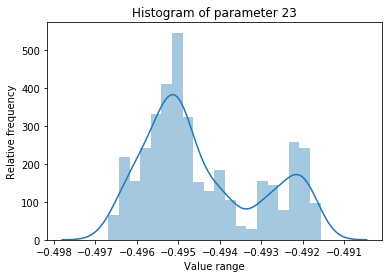

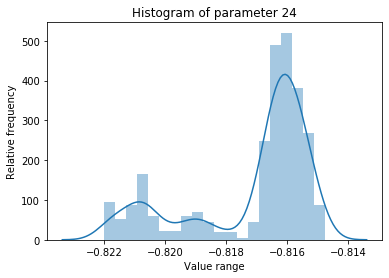

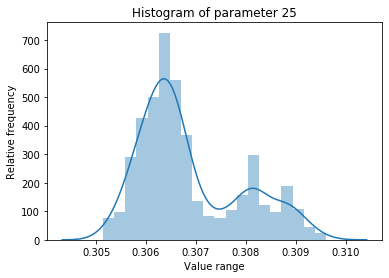

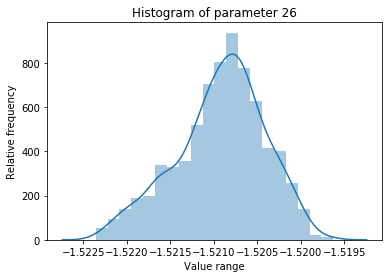

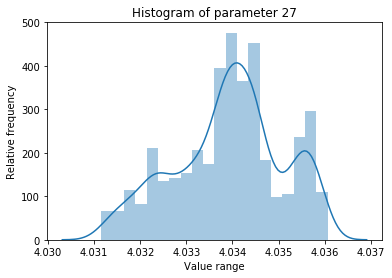

In [11]:
## Plot histograms of simulated Markov chain

for i in range(sampler.models[0].num_params()):
    plt.figure()
    sns.distplot(sampler.samplers[0].chain.get_theta(i), bins=20, norm_hist=True)
    plt.xlabel('Value range')
    plt.ylabel('Relative frequency')
    plt.title(r'Histogram of parameter {}'.format(i+1))